In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from  math import cos,sin,pi
import random

#### <center> Data preparation </center>

In [76]:
data = pd.read_csv("data_v6.csv")
data.tail()

,target,nlos_indicator,t1,t2,t3,t4,skew,tof,tof_skew,range,...,loc_target_x,loc_target_y,loc_target_z,temperature_initiator,temperature_target,rssi_request,rssi_ack,rssi_data,rssi_mean,orientation
3941,184,3.075243,301428484750,302000434919,302102988430,301531040251,-9.382925,995,1476.125937,4.666893,...,2.12,2.793,2.65,41.810001,46.939999,-80.229179,-79.428015,-79.342829,-79.666674,119.0
3942,184,3.085177,375355600014,375928251294,376031194254,375458544956,-8.306196,991,1418.532184,4.648132,...,2.12,2.793,2.65,41.525002,47.319996,-80.196487,-79.576395,-79.985511,-79.919464,119.0
3943,184,2.674524,449294310542,449867663034,449970544782,449397194279,-8.952233,994,1455.010695,4.662203,...,2.12,2.793,2.65,41.810001,46.939999,-80.158638,-79.435472,-79.234453,-79.609521,119.0
3944,184,2.727551,523279420046,523853474064,523955982478,523381930458,-8.490778,999,1434.188082,4.685655,...,2.12,2.793,2.65,41.240002,46.559998,-80.229492,-79.554364,-79.599858,-79.794571,119.0
3945,184,2.676824,597204949646,597779704639,597883435662,597308682642,-9.936671,986,1501.870529,4.624680,...,2.12,2.793,2.65,41.525002,46.939999,-79.617264,-79.487352,-79.358943,-79.487853,119.0


Fixed sensors List:

In [77]:
data["target"].unique()

array([100, 101, 150, 171, 180, 184])

## <center> Generate new data </center>
To train the model, we decide to implement some modifications on the data generating new rows, to generate the new data set we have 2 methods.
First, we modify the origin of the system by re-calculating the coordinates of the initiator and the target.
The second approach is to turn the system around the origin. 
### I-change System Origin 


In [78]:
#   dff : dataframe source
#   origin : sensors id 

def changeSystemOrigin(dff,origin) :
    df=dff.copy()
    
    x = list(data.loc_target_x[df["target"]==origin])[0]
    y = list(df.loc_target_y[df["target"]==origin])[0]
    
    for index, row in df.iterrows():
        #update coordinates of the new origin
        if(row["target"]==origin):
            df.at[index,"loc_target_x"] =0
            df.at[index,"loc_target_y"]=0
        #re-calculiting new coordinates of the initiator    
        df.at[index,"loc_initiator_x"] = df.at[index,"loc_initiator_x"] -x
        df.at[index,"loc_initiator_y"]= df.at[index,"loc_initiator_y"] -y
        #re-calculiting new coordinates of the target
        df.at[index,"loc_target_x"]= df.at[index,"loc_target_x"] -x
        df.at[index,"loc_target_y"]= df.at[index,"loc_target_y"] -y
    
    return df

### II-rotation sensors around the origin

In [79]:
def getOrientation(orientation,rotateAngle):
    sum = orientation+rotateAngle
    if(sum>360):
        sum= sum-360
    return sum
#rotate System around the origin 
#   dff : dataframe source
#   angle : rotation angle 
      
def rotation(df, angle):
    df_c = df.copy()
    angle_rad = angle * pi / 180
    for index, row in df.iterrows():
        #re-calculiting new coordinates of the initiator [rotation]    
        df_c.at[index,"loc_initiator_x"] = df.at[index,"loc_initiator_x"] * cos(angle_rad) - df.at[index,"loc_initiator_y"] * sin(angle_rad)
        df_c.at[index,"loc_initiator_y"] = -df.at[index,"loc_initiator_x"] * sin(angle_rad) + df.at[index,"loc_initiator_y"]  * cos(angle_rad)
        #re-calculiting new coordinates of the target [rotation]
        df_c.at[index,"loc_target_x"]=  df.at[index,"loc_target_x"] * cos(angle_rad) - df.at[index,"loc_target_y"] * sin(angle_rad)
        df_c.at[index,"loc_target_y"] = -df.at[index,"loc_target_x"] *  sin(angle_rad) + df.at[index,"loc_target_y"] * cos(angle_rad)
        df_c.at[index,'orientation']= getOrientation(df_c.at[index,'orientation'],angle)
    return df_c

### III- Functions to plot initiator paths

In [80]:
# Update position dataset to show path after changing origin
## df : dateframe source
## angle : rotation angle
def changeSystemOriginPosition(dff,origin) :
    df=dff.copy()
    x = list(df.x[df["node_id"]==origin])[0]
    y = list(df.y[df["node_id"]==origin])[0]
    for index, row in df.iterrows():
        if(row["node_id"]==origin):
            #new origin
             df.at[index,"x"] =0
             df.at[index,"y"]=0
        df.at[index,"x"]= df.at[index,"x"] -x
        df.at[index,"y"]= df.at[index,"y"] -y
    return df


# Update position dataset to display path  after rotating system 
## df : dateframe source
## angle : rotation angle
def rotationPosition(df, angle):
    df_c = df.copy()
    angle_rad = angle * pi / 180
    df_c.x = df.x * cos(angle_rad) - df.y * sin(angle_rad)
    df_c.y = -df.x * sin(angle_rad) + df.y * cos(angle_rad)
    return df_c


##get OX,OY Span after a rotation
#orientationAngle : orientation angle (degree)
def getOriginOrientation(orientationAngle):
    angle_rad = orientationAngle * pi / 180
    x1=1
    y1=0
    x2=0
    y2=1
    return [[0,0,x1 * cos(angle_rad) - y1 * sin(angle_rad)],[0,0,x1 * sin(angle_rad) + y1 * cos(angle_rad)],[0,0,x2 * cos(angle_rad) - y2 * sin(angle_rad)],[0,0,x2 * sin(angle_rad) + y2 * cos(angle_rad)]]    


# plot intiator path on the room 
## df : dateframe source
def plotInitiatorPath(df,position,orientation) :
    fig, ax = plt.subplots()
    ax.plot(list(-df['loc_initiator_x']),list(-df['loc_initiator_y']),label='emetteur')
    ax.set_title("Trajet de l'emetteur")
    plt.xlabel('abscisse')
    plt.ylabel('ordonné')
    x = getOriginOrientation(orientation)
    plt.plot(x[0],x[1],"g",label="X")
    plt.plot(x[2],x[3],"y",label="Y")
    plt.plot(0,0,"^b",label='origine')   
    plt.axis('equal')
    plt.plot(-position['x'],-position['y'],"^r",label='capteur')
    plt.legend()
    plt.show()
    

In [24]:
position=pd.read_csv("positions.csv")

In [81]:
data_test = data.copy()
position_test =position.copy()
data_test[["loc_initiator_x","loc_initiator_y","loc_target_x","loc_target_y"]].head()

,loc_initiator_x,loc_initiator_y,loc_target_x,loc_target_y
0,2.12,2.793,-3.962,7.931
1,2.12,2.793,-3.962,7.931
2,2.12,2.793,-3.962,7.931
3,2.12,2.793,-3.962,7.931
4,2.12,2.793,-3.962,7.931


### VI Paths

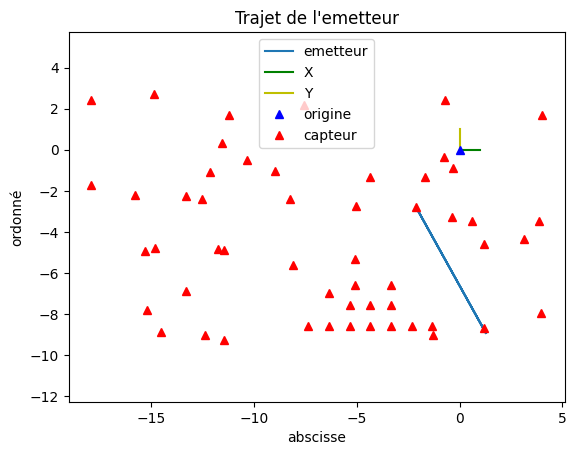

In [82]:
#origin path
plotInitiatorPath(data_test,position_test,0)

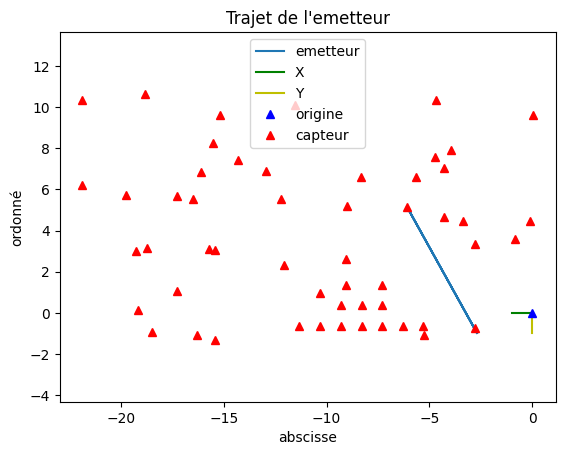

In [83]:
#new origin sensor 100
plotInitiatorPath(changeSystemOrigin(data_test,100),changeSystemOriginPosition(position,100),180)

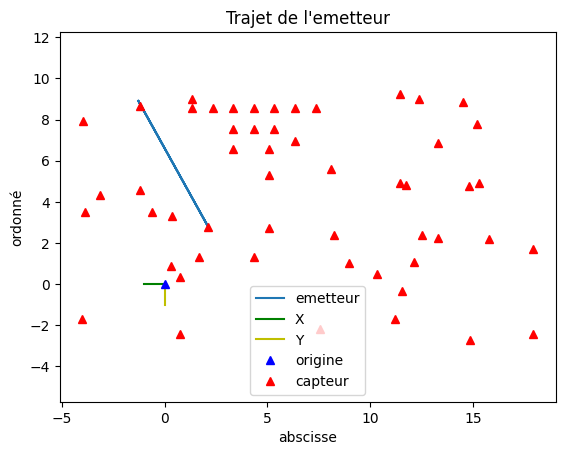

In [84]:
#rotating system around the origin with 90°
plotInitiatorPath(rotation(data_test,180),rotationPosition(position,180),180)

### V Generate new dataset

In [86]:
#add 2 column origin rotation 
#original dataset  origin = 0 roation = 0  
data["origin"]=[0 for i in range(len(data))]
data["rotation"]=[0 for i in range(len(data))]
data_d = data.copy()

In [87]:
##get 10 different angles
def getAngales():
    random_numbers = []
    for i in range(10):
        random_numbers.append(random.randint(1, 359))
    return random_numbers    

In [88]:

data_complet =data.copy() 
d0 = data.copy()
angles = getAngales()
for i in angles:
    dr= d0.copy()
    dr=rotation(d0,i)
    dr["rotation"]=i
    data_complet=pd.concat([data_complet,dr],ignore_index=True)
    
df_copy = data.copy()
d1=changeSystemOrigin(df_copy,100)
d1["origin"]=100
data_complet=pd.concat([data_complet,d1],ignore_index=True)
angles = getAngales()
for i in angles:
    dr= d1.copy()
    dr=rotation(d1,i)
    dr["rotation"]=i
    data_complet=pd.concat([data_complet,dr],ignore_index=True)
df_copy = data.copy() 
d2=changeSystemOrigin(df_copy,101)
d2["origin"]=101
data_complet=pd.concat([data_complet,d2],ignore_index=True)
angles = getAngales()
for i in angles:
    dr= d2.copy()
    dr=rotation(d2,i)
    dr["rotation"]=i
    data_complet=pd.concat([data_complet,dr],ignore_index=True)

df_copy = data.copy() 
d3=changeSystemOrigin(data_d,150)
d3["origin"]=150
data_complet=pd.concat([data_complet,d3],ignore_index=True)
angles = getAngales()
for i in angles:
    dr= d3.copy()
    dr=rotation(d3,i)
    dr["rotation"]=i
    data_complet=pd.concat([data_complet,dr],ignore_index=True)

df_copy = data.copy() 
d4=changeSystemOrigin(df_copy,171)
d4["origin"]=171
data_complet=pd.concat([data_complet,d4],ignore_index=True)
angles = getAngales()
for i in angles:
    dr= d4.copy()
    dr=rotation(d4,i)
    dr["rotation"]=i
    data_complet=pd.concat([data_complet,dr],ignore_index=True)    


df_copy = data.copy() 
d4=changeSystemOrigin(df_copy,180)
d4["origin"]=180
data_complet=pd.concat([data_complet,d4],ignore_index=True)
angles = getAngales()
for i in angles:
    dr= d4.copy()
    dr=rotation(d4,i)
    dr["rotation"]=i
    data_complet=pd.concat([data_complet,dr],ignore_index=True)


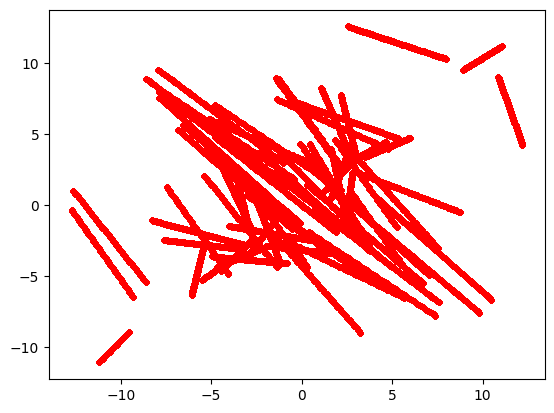

In [92]:
plt.plot(data_complet['loc_initiator_x'],data_complet['loc_initiator_y'],"r.")

In [93]:
data_complet.to_csv("complet.csv")

In [90]:
d1=changeSystemOrigin(data_d,100)
d1["origin"]=100
data_d = data.copy() 
d2=changeSystemOrigin(data_d,101)
d2["origin"]=101
data_d = data.copy() 
d3=changeSystemOrigin(data_d,150)
d3["origin"]=150
data_d = data.copy() 
d4=changeSystemOrigin(data_d,171)
d4["origin"]=171
data_d = data.copy() 
d4=changeSystemOrigin(data_d,180)
d4["origin"]=180



In [ ]:
t1=rotation(data_d,50)
t1["rotation"]=50
data_d = data.copy() 
t2=rotation(data_d,75)
t2["rotation"]=75
data_d = data.copy() 
t3=rotation(data_d,90)
t3["rotation"]=90
data_d = data.copy() 
t4=rotation(data_d,270)
t4["rotation"]=270
data_d = data.copy() 
t4=rotation(data_d,180)
t4["rotation"]=180

In [ ]:
csv_rotation=pd.concat([data,t1,t2,t3,t4],ignore_index=True)
len(csv_rotation)

19730

In [ ]:
csv_origin_position=pd.concat([data,d1,d2,d3,d4],ignore_index=True)
len(csv_origin_position)

19730

In [ ]:
csv_origin_position.to_csv("origin_position.csv")

In [ ]:
csv_rotation.to_csv("rotation.csv")

In [ ]:
csv_complet=pd.concat([csv_origin_position,csv_rotation],ignore_index=True)
csv_complet.to_csv("complet.csv")

In [ ]:
data_complet[(data_complet['origin'] != 0) | (data_complet['rotation'] != 0)]

,Unnamed: 0,initiator,target,protocol,nlos_indicator,t1,t2,t3,t4,skew,...,timestamp,seqnum,rssi_request,rssi_ack,rssi_data,rssi_mean,register_dump_CIR,orientation,origin,rotation
3946,0,183,100,TWR,2.783982,946218857614,946490292658,946594234510,946322802711,-2.368804,...,1654929794228,4,-80.136574,-80.077130,-79.836296,-80.016667,"{""ACC_MEM"": ""AAT/9gACAAr/+wABAAL/8wAS//AACgAGA...",270.0,0,31
3947,1,183,100,TWR,2.920485,1009474709646,1009746235572,1009850439822,1009578917162,-1.045965,...,1654929795219,10,-80.267769,-79.988684,-79.835720,-80.030724,"{""ACC_MEM"": ""//gAEwAC//X/9gAXABEACwASABQAFgAG/...",270.0,0,31
3948,2,183,100,TWR,2.536090,1072923068046,1073194681670,1073299179662,1073027569304,-0.799856,...,1654929796210,16,-79.964310,-79.850138,-79.693502,-79.835983,"{""ACC_MEM"": ""//QABQAJ//X/9gAUABMADv/3//r//gAK/...",270.0,0,31
3949,3,183,100,TWR,2.857669,36731534990,37003232943,37107270798,36835576116,-0.984438,...,1654929797201,22,-80.040833,-79.818313,-79.849525,-79.902890,"{""ACC_MEM"": ""ACb//AAa//4ADQAJAAYALf/+ABQAEgAOA...",270.0,0,31
3950,4,183,100,TWR,2.263103,99923195534,100194974620,100298828942,100027053147,-0.769092,...,1654929798190,28,-79.999908,-80.102552,-80.022316,-80.041592,"{""ACC_MEM"": ""//b/+P/6//3/8QAI//H//P/1AAkAAv/3A...",270.0,0,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260431,3941,183,184,TWR,3.075243,301428484750,302000434919,302102988430,301531040251,-9.382925,...,1654930833773,4231,-80.229179,-79.428015,-79.342829,-79.666674,"{""ACC_MEM"": ""ABH//QAT//YABQASAAIAFwAUAAsAAv/3A...",119.0,180,212
260432,3942,183,184,TWR,3.085177,375355600014,375928251294,376031194254,375458544956,-8.306196,...,1654930834930,4237,-80.196487,-79.576395,-79.985511,-79.919464,"{""ACC_MEM"": ""ABkADQAOAAgABv/7ABgABAAG//n////w/...",119.0,180,212
260433,3943,183,184,TWR,2.674524,449294310542,449867663034,449970544782,449397194279,-8.952233,...,1654930836088,4243,-80.158638,-79.435472,-79.234453,-79.609521,"{""ACC_MEM"": ""AA8AAQAE/////P/zABz/+P////8AAwAAA...",119.0,180,212
260434,3944,183,184,TWR,2.727551,523279420046,523853474064,523955982478,523381930458,-8.490778,...,1654930837246,4249,-80.229492,-79.554364,-79.599858,-79.794571,"{""ACC_MEM"": ""ABoACwAEABEACQADAAL//wAPAAYAFP/4A...",119.0,180,212


,Unnamed: 0,initiator,target,protocol,nlos_indicator,t1,t2,t3,t4,skew,...,timestamp,seqnum,rssi_request,rssi_ack,rssi_data,rssi_mean,register_dump_CIR,orientation,origin,rotation
260431,260431,183,184,TWR,3.075243,301428484750,302000434919,302102988430,301531040251,-9.382925,...,1654930833773,4231,-80.229179,-79.428015,-79.342829,-79.666674,"{""ACC_MEM"": ""ABH//QAT//YABQASAAIAFwAUAAsAAv/3A...",235.0,180,116
260432,260432,183,184,TWR,3.085177,375355600014,375928251294,376031194254,375458544956,-8.306196,...,1654930834930,4237,-80.196487,-79.576395,-79.985511,-79.919464,"{""ACC_MEM"": ""ABkADQAOAAgABv/7ABgABAAG//n////w/...",235.0,180,116
260433,260433,183,184,TWR,2.674524,449294310542,449867663034,449970544782,449397194279,-8.952233,...,1654930836088,4243,-80.158638,-79.435472,-79.234453,-79.609521,"{""ACC_MEM"": ""AA8AAQAE/////P/zABz/+P////8AAwAAA...",235.0,180,116
260434,260434,183,184,TWR,2.727551,523279420046,523853474064,523955982478,523381930458,-8.490778,...,1654930837246,4249,-80.229492,-79.554364,-79.599858,-79.794571,"{""ACC_MEM"": ""ABoACwAEABEACQADAAL//wAPAAYAFP/4A...",235.0,180,116
260435,260435,183,184,TWR,2.676824,597204949646,597779704639,597883435662,597308682642,-9.936671,...,1654930838402,4255,-79.617264,-79.487352,-79.358943,-79.487853,"{""ACC_MEM"": ""AAf/8QACAAYAA///AAn/8f/y//z/5P/+/...",235.0,180,116
